# Example 3: -  Including systematics

## Preparations

Let us first load all the python libraries again

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

To not forget anything later, let us globaly define the number of events in the MG sample

In [4]:
inputfile = 'data/madminer_lhedata_signal.h5'
nsamples = 100000

## 4. Data Augmentation and Machine Learning

### 4a) Make (unweighted) training and test samples with augmented data

Let us make event samples using the `SampleAugmenter`.  For simplicity we use the local data and later train Sally. 

In [5]:
#Define n_estimator
n_estimators = 5

#Initialize
sa  = SampleAugmenter(inputfile)

#augment train sample
for i in range(n_estimators):
    _ , _ , _ = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'), n_samples=int(nsamples/2),
        folder='./data/samples_ensemble/', filename='train{}'.format(i),
        nuisance_score=True
    )
    
#augment test sample
_ , _ , _ = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'), n_samples=int(nsamples/2),
    folder='./data/samples_ensemble/', filename='test', 
    switch_train_test_events=True,
    nuisance_score=True
)

#augment test sample
#_ , _ = sa.extract_samples_test(
#    theta=constant_benchmark_theta('sm'), n_samples=int(nsamples/2),
#    folder='./data/samples_ensemble/', filename='test'
#)

13:26 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
13:26 madminer.sampling    INFO    Found 2 parameters
13:26 madminer.sampling    INFO    Found 33 nuisance parameters
13:26 madminer.sampling    INFO    Found 45 benchmarks, of which 6 physical
13:26 madminer.sampling    INFO    Found 14 observables
13:26 madminer.sampling    INFO    Found 3338 events
13:26 madminer.sampling    INFO    Found morphing setup with 6 components
13:26 madminer.sampling    INFO    Found nuisance morphing setup
13:26 madminer.sampling    INFO    Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
13:26 madminer.sampling    INFO    Effective number of samples: 1668.9999999999795
13:26 madminer.sampling    INFO    Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
13:26 madminer.sampling    INFO    Effective number of samples: 1668.99999999997

### 4b)  Train a neural network to estimate the score

We can now set up an EnsembleForge and train it.

In [6]:
ensemble = EnsembleForge(estimators=n_estimators)
ensemble.train_all(
    method='sally',
    x_filename=['data/samples_ensemble/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_ensemble/t_xz_train{}.npy'.format(i) for i in range(n_estimators)]
)
ensemble.save('models/samples_ensemble')

13:26 madminer.ml          INFO    Training 5 estimators in ensemble
13:26 madminer.ml          INFO    Training estimator 1 / 5 in ensemble
13:26 madminer.ml          INFO    Starting training
13:26 madminer.ml          INFO      Method:                 sally
13:26 madminer.ml          INFO      Training data:          x at data/samples_ensemble/x_train0.npy
13:26 madminer.ml          INFO                              t_xz (theta0) at data/samples_ensemble/t_xz_train0.npy
13:26 madminer.ml          INFO      Features:               all
13:26 madminer.ml          INFO      Method:                 sally
13:26 madminer.ml          INFO      Hidden layers:          (100, 100)
13:26 madminer.ml          INFO      Activation function:    tanh
13:26 madminer.ml          INFO      Batch size:             128
13:26 madminer.ml          INFO      Trainer:                amsgrad
13:26 madminer.ml          INFO      Epochs:                 50
13:26 madminer.ml          INFO      Learning rate:   

13:30 madminer.ml          INFO      Features:               all
13:30 madminer.ml          INFO      Method:                 sally
13:30 madminer.ml          INFO      Hidden layers:          (100, 100)
13:30 madminer.ml          INFO      Activation function:    tanh
13:30 madminer.ml          INFO      Batch size:             128
13:30 madminer.ml          INFO      Trainer:                amsgrad
13:30 madminer.ml          INFO      Epochs:                 50
13:30 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
13:30 madminer.ml          INFO      Validation split:       None
13:30 madminer.ml          INFO      Early stopping:         True
13:30 madminer.ml          INFO      Scale inputs:           True
13:30 madminer.ml          INFO      Shuffle labels          False
13:30 madminer.ml          INFO      Regularization:         None
13:30 madminer.ml          INFO      Samples:                all
13:30 madminer.ml          INFO    Load

## 5. Data Analysis

### 5a) Setup Fisher Information

Let us first set up the Fisher Information class

In [7]:
fisher = FisherInformation(inputfile)

13:33 madminer.fisherinfor INFO    Loading data from data/madminer_lhedata_signal.h5
13:33 madminer.fisherinfor INFO    Found 2 parameters
13:33 madminer.fisherinfor INFO    Found 33 nuisance parameters
13:33 madminer.fisherinfor INFO    Found 45 benchmarks, of which 6 physical
13:33 madminer.fisherinfor INFO    Found 14 observables: m_Z, m_H, m_ZH, pt_Z, pt_H, eta_Z, eta_H, dphi_mumu, dphi_mupmum, dphi_tata, dphi_mupH, dphi_mumH, pt_mup, pt_mum
13:33 madminer.fisherinfor INFO    Found 3338 events
13:33 madminer.fisherinfor INFO    Found morphing setup with 6 components
13:33 madminer.fisherinfor INFO    Found nuisance morphing setup


### 5b) Evaluate Fisher Information - Full, Rate and Histograms

Let us first look at the Fisher Information in the full data, in the rate only and in a few kinematic distributions

In [8]:
fi_full_mean, fi_full_cov = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,
    model_file='models/samples_ensemble',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
)

fi_rate_mean, fi_rate_cov = fisher.calculate_fisher_information_rate(
    theta=[0.,0.],luminosity=300*1000.
)

fi_dphi_mean, fi_dphi_cov = fisher.calculate_fisher_information_hist1d(
    theta=[0.,0.], luminosity=300*1000.,
    observable='dphi_mumu',nbins=20,histrange=(-3.2,3.2)
)

13:33 madminer.ml          INFO    Found ensemble with 5 estimators and expectations None
13:33 madminer.fisherinfor INFO    Evaluating rate Fisher information
/Users/johannbrehmer/work/projects/madminer/madminer/madminer/fisherinformation.py:1352: RuntimeWarning: divide by zero encountered in true_divide
  inv_sigma = sanitize_array(1.0 / sigma)  # Shape (n_events,)
/Users/johannbrehmer/work/projects/madminer/madminer/madminer/morphing.py:697: RuntimeWarning: invalid value encountered in true_divide
  a.append(0.5 * np.log(benchmark_weights[:, i_pos] / benchmark_weights[:, i_neg]))
/Users/johannbrehmer/work/projects/madminer/madminer/madminer/morphing.py:695: RuntimeWarning: invalid value encountered in true_divide
  a.append(np.log(benchmark_weights[:, i_pos] / benchmark_weights[:, self.i_benchmark_ref]))


### 5c) No Systematics

To again obtain the Fisher Information without systematics, we can use `project_information()` to project out the nuisance parameter (set them all to zero).

In [9]:
fi_full_mean_proj, fi_full_cov_proj = project_information(
    fisher_information=fi_full_mean, covariance=fi_full_cov,remaining_components=[0,1])
fi_rate_mean_proj, fi_rate_cov_proj = project_information(
    fisher_information=fi_rate_mean, covariance=fi_rate_cov,remaining_components=[0,1])
fi_dphi_mean_proj, fi_dphi_cov_proj = project_information(
    fisher_information=fi_dphi_mean, covariance=fi_dphi_cov,remaining_components=[0,1])

Let's plot the result

/Users/johannbrehmer/work/projects/madminer/madminer/madminer/plotting.py:963: RuntimeWarning: invalid value encountered in sqrt
  uncertainties = (var ** 0.5).reshape((resolution, resolution))
/Users/johannbrehmer/work/projects/madminer/madminer/madminer/plotting.py:976: RuntimeWarning: invalid value encountered in greater
  band = (d2_up > d2_threshold) * (d2_down < d2_threshold) + (d2_up < d2_threshold) * (d2_down > d2_threshold)
/Users/johannbrehmer/work/projects/madminer/madminer/madminer/plotting.py:976: RuntimeWarning: invalid value encountered in less
  band = (d2_up > d2_threshold) * (d2_down < d2_threshold) + (d2_up < d2_threshold) * (d2_down > d2_threshold)
/Users/johannbrehmer/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/johannbrehmer/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an a

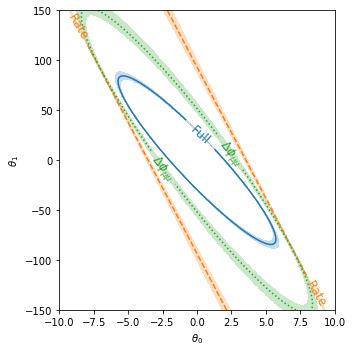

In [10]:
_ = plot_fisher_information_contours_2d(
    [fi_full_mean_proj, fi_rate_mean_proj, fi_dphi_mean_proj],
    [fi_full_cov_proj , fi_rate_cov_proj , fi_dphi_cov_proj ],
    inline_labels=["Full","Rate","$\Delta\phi_{\mu\mu}$"],
    xrange=(-10,10),
    yrange=(-150,150)
)

### 5d) Including Systematics

We can also profile over the systematics. The nuisance parameters, by construction, follow Gaussian distributions with mean $\langle \nu \rangle=0 $ and width $\sigma_\nu=1$. This provides an additional contribution to the Fisher Information, $I_{ij}^{}=I_{ij}^{0}+I_{ij}^{\nu}$, where $I_{ij}$ is the total Fisher Info, $I^0_{ij}$ is the Fisher Information obtained by the analyzed process only and $I_{ij}^\nu = \delta_{ik}\delta_{kj}/{\sigma_\nu^2}$ is the addition contribution from the constraints of the nuisance parameter. Let's first calulate the Fisher Info for the nuisance parameter:

In [11]:
fi_nuisance = fisher.calculate_fisher_information_nuisance_constraints()

Now we can add the two Fisher Informations, and also profile over the nuisance parameters

In [12]:
fi_full_mean_prof, fi_full_cov_prof = profile_information(
    fisher_information=fi_full_mean+fi_nuisance, covariance=fi_full_cov,remaining_components=[0,1])
fi_rate_mean_prof, fi_rate_cov_prof = profile_information(
    fisher_information=fi_rate_mean+fi_nuisance, covariance=fi_rate_cov,remaining_components=[0,1])
fi_dphi_mean_prof, fi_dphi_cov_prof = profile_information(
    fisher_information=fi_dphi_mean+fi_nuisance, covariance=fi_dphi_cov,remaining_components=[0,1])

Let's now plot the result

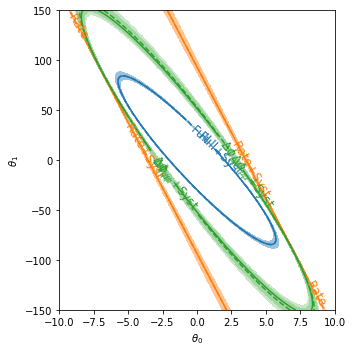

In [13]:
_ = plot_fisher_information_contours_2d(
    [fi_full_mean_proj,fi_full_mean_prof,fi_rate_mean_proj,fi_rate_mean_prof,fi_dphi_mean_proj,fi_dphi_mean_prof],
    [fi_full_cov_proj ,fi_full_cov_prof ,fi_rate_cov_proj ,fi_rate_cov_prof ,fi_dphi_cov_proj ,fi_dphi_cov_prof ],
    inline_labels=["Full","Full+Syst","Rate","Rate+Syst","$\Delta\phi_{\mu\mu}$","$\Delta\phi_{\mu\mu}$+Syst"],
    linestyles=["solid","dashed","solid","dashed","solid","dashed"],
    colors=["C0","C0","C1","C1","C2","C2"],
    xrange=(-10,10),
    yrange=(-150,150),
)

### 5e) Comparing different Systematics

We can also compare different systematics separatly, for example scale and PDF uncertainties. To do this, we first project out one and then profile over the other. Let us for simplicity define two functions that do that. 

In [14]:
def profile_and_project_information(
    fi_mean, 
    fi_cov, 
    fi_nuisance, 
    remaining_components_project, 
    remaining_components_profile):
    
    #Project Out Components
    fi_mean_projected,fi_cov_projected = project_information(
        fisher_information=fi_mean, 
        covariance=fi_cov,
        remaining_components=remaining_components_project
    )
    fi_nuisance_projected = project_information(
        fisher_information=fi_nuisance, 
        remaining_components=remaining_components_project,
    )
    
    #Profile over Components
    fi_mean_profiled, fi_cov_profiled = profile_information(
        fisher_information=fi_mean_projected+fi_nuisance_projected, 
        covariance=fi_cov_projected,
        remaining_components=remaining_components_profile,
    )
    
    return fi_mean_profiled, fi_cov_profiled

def get_data_for_plot(fi_mean, fi_cov, fi_nuisance):
    
    #Define Components
    components_plot=[0,1]
    components_scale=components_plot+[2,3]
    components_pdf=components_plot+[i for i in range(4,34)]
    components_all=components_plot+[i for i in range(2,34)]

    #Calculate Fisher Informations
    fi_m_nosyst, fi_c_nosyst = profile_and_project_information(
        fi_mean=fi_mean,fi_cov=fi_cov,fi_nuisance=fi_nuisance,
        remaining_components_project=components_plot,
        remaining_components_profile=components_plot)
    fi_m_scale, fi_c_scale = profile_and_project_information(
        fi_mean=fi_mean,fi_cov=fi_cov,fi_nuisance=fi_nuisance,
        remaining_components_project=components_scale,
        remaining_components_profile=components_plot)
    fi_m_pdf, fi_c_pdf = profile_and_project_information(
        fi_mean=fi_mean,fi_cov=fi_cov,fi_nuisance=fi_nuisance,
        remaining_components_project=components_pdf,
        remaining_components_profile=components_plot)
    fi_m_all, fi_c_all = profile_and_project_information(
        fi_mean=fi_mean,fi_cov=fi_cov,fi_nuisance=fi_nuisance,
        remaining_components_project=components_all,
        remaining_components_profile=components_plot)
    
    return [fi_m_nosyst,fi_m_scale,fi_m_pdf,fi_m_all], [fi_c_nosyst,fi_c_scale,fi_c_pdf,fi_c_all]


Now we can calculate the Fisher Infos cosnidering only scale and only PDF uncertainties

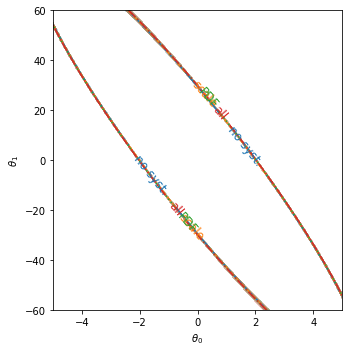

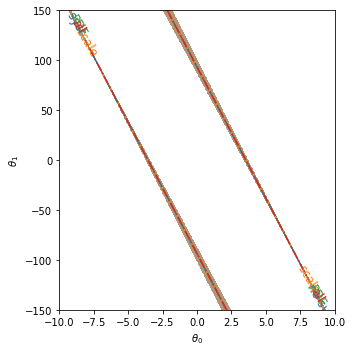

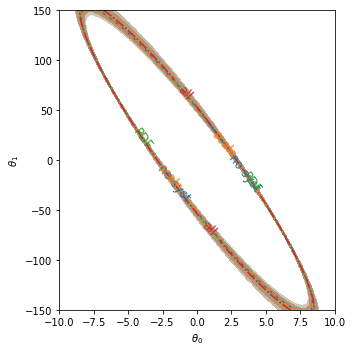

In [15]:
use_labels=["no syst.","scale","PDF","all"]

mean_full, cov_full = get_data_for_plot(fi_full_mean, fi_full_cov, fi_nuisance)
_ = plot_fisher_information_contours_2d(
    mean_full,cov_full,inline_labels=use_labels,xrange=(-5,5),yrange=(-60,60))

mean_rate, cov_rate = get_data_for_plot(fi_rate_mean, fi_rate_cov, fi_nuisance)
_ = plot_fisher_information_contours_2d(
    mean_rate,cov_rate,inline_labels=use_labels,xrange=(-10,10),yrange=(-150,150))

mean_dphi, cov_dphi = get_data_for_plot(fi_dphi_mean, fi_dphi_cov, fi_nuisance)
_ = plot_fisher_information_contours_2d(
    mean_dphi,cov_dphi,inline_labels=use_labels,xrange=(-10,10),yrange=(-150,150))